**CMB ResMLP Emulator testing Tutorial**\
This notebook demonstrates how to test a trained Transformer model on CMB TT power spectrum.\
Similar work applies for TE and EE as well.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import camb
import scipy.linalg
from camb import model, initialpower
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid

In [2]:
#Set up the ell range
camb_ell_min          = 2#30
camb_ell_max          = 5000
camb_ell_range        = camb_ell_max  - camb_ell_min 

#load test data
testing_samples=np.load('parametersamples/cos_pkc_T128.npy',allow_pickle=True)[10000:]

testing_data_vectors=np.load('datavectors/Planck128/cos_pkc_T128_TT_acc.npy',allow_pickle=True)[10000:,:4998]

In [3]:
#set device
#I prefer using CPU for model usage after training
device = torch.device('cpu')

#set the number of channels and internal dimension of the ResMLP blocks in the TRF
nc=32
intdim=4

In [4]:
#Load normalization factors of the model, and model parameters

PATH = "./trainedemu5000plktrf/chiTTAstautrf150k256val128i5120evansqrtc"+str(nc)
extrainfo=np.load("extra/extrainfo_plk_tt_third_T256.npy",allow_pickle=True)
X_mean=torch.Tensor(extrainfo.item()['X_mean']).to(device)
X_std=torch.Tensor(extrainfo.item()['X_std']).to(device)
Y_mean=torch.Tensor(extrainfo.item()['Y_mean']).to(device)
Y_std=torch.Tensor(extrainfo.item()['Y_std']).to(device)

In [5]:
#ML modules
class Supact(nn.Module):
    # New activation function, returns:
    # f(x)=(gamma+(1+exp(-beta*x))^(-1)*(1-gamma))*x
    # gamma and beta are trainable parameters.
    # I chose the initial value for gamma to be all 1, and beta to be all 0
    def __init__(self, in_size):
        super(Supact, self).__init__()
        
        self.gamma = nn.Parameter(torch.ones(in_size))
        self.beta = nn.Parameter(torch.zeros(in_size))
        self.m = nn.Sigmoid()
    def forward(self, x):
        inv = self.m(torch.mul(self.beta,x))
        fac = 1-self.gamma
        mult = self.gamma + torch.mul(inv,fac)
        return torch.mul(mult,x)

class Affine(nn.Module):
    def __init__(self):
        super(Affine, self).__init__()

        # This function is designed for the Neuro-network to learn how to normalize the data between
        # layers. we will initiate gains and bias both at 1 
        self.gain = nn.Parameter(torch.ones(1))

        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        return x * self.gain + self.bias

class Better_Attention(nn.Module):
    def __init__(self, in_size ,n_partitions):
        super(Better_Attention, self).__init__()

        self.embed_dim    = in_size//n_partitions
        self.WQ           = nn.Linear(self.embed_dim,self.embed_dim)
        self.WK           = nn.Linear(self.embed_dim,self.embed_dim)
        self.WV           = nn.Linear(self.embed_dim,self.embed_dim)

        self.act          = nn.Softmax(dim=1) #NOT along the batch direction, apply to each vector.
        self.scale        = np.sqrt(self.embed_dim)
        self.n_partitions = n_partitions # n_partions or n_channels are synonyms 
        self.norm         = torch.nn.LayerNorm(in_size) # layer norm has geometric order (https://lessw.medium.com/what-layernorm-really-does-for-attention-in-transformers-4901ea6d890e)

    def forward(self, x):
        x_norm    = self.norm(x)
        batch_size = x.shape[0]
        _x = x_norm.reshape(batch_size,self.n_partitions,self.embed_dim) # put into channels

        Q = self.WQ(_x) # query with q_i as rows
        K = self.WK(_x) # key   with k_i as rows
        V = self.WV(_x) # value with v_i as rows

        dot_product = torch.bmm(Q,K.transpose(1, 2).contiguous())
        normed_mat  = self.act(dot_product/self.scale)
        prod        = torch.bmm(normed_mat,V)

        #out = torch.cat(tuple([prod[:,i] for i in range(self.n_partitions)]),dim=1)+x
        out = torch.reshape(prod,(batch_size,-1))+x # reshape back to vector

        return out

class Better_Transformer(nn.Module):
    def __init__(self, in_size, n_partitions):
        super(Better_Transformer, self).__init__()  
    
        # get/set up hyperparams
        self.int_dim      = in_size//n_partitions 
        self.n_partitions = n_partitions
        self.act          = Supact(in_size)#nn.Tanh()#nn.ReLU()#
        self.norm         = Affine()#torch.nn.BatchNorm1d(in_size)

        # set up weight matrices and bias vectors
        weights = torch.zeros((n_partitions,self.int_dim,self.int_dim))
        self.weights = nn.Parameter(weights) # turn the weights tensor into trainable weights
        bias = torch.Tensor(in_size)
        self.bias = nn.Parameter(bias) # turn bias tensor into trainable weights

        # initialize weights and biases
        # this process follows the standard from the nn.Linear module (https://auro-227.medium.com/writing-a-custom-layer-in-pytorch-14ab6ac94b77)
        nn.init.kaiming_uniform_(self.weights, a=np.sqrt(5)) # matrix weights init 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights) # fan_in in the input size, fan out is the output size but it is not use here
        bound = 1 / np.sqrt(fan_in) 
        nn.init.uniform_(self.bias, -bound, bound) # bias weights init

    def forward(self,x):
        mat = torch.block_diag(*self.weights) # how can I do this on init rather than on each forward pass?
        x_norm = self.norm(x)
        #_x = x_norm.reshape(x_norm.shape[0],self.n_partitions,self.int_dim) # reshape into channels
        o = self.act(torch.matmul(x_norm,mat)+self.bias)
        return o+x

class AttnLayer(nn.Module):
    def __init__(self, in_size, n_partitions, n_heads, att):
        super(AttnLayer, self).__init__()
        
        self.n_heads       = n_heads
        self.n_partitions  = n_partitions
        self.d_model       = in_size//n_partitions
        
        # Types of Attention I tested:
        
        # att = FullAttention()  <- Standard
        # att = LinearAttention(int_dim_trf//n_channels)
        # att = ReformerAttention()
        # att = AFTFullAttention(max_sequence_length = n_channels, aft_parameterization = n_channels)
        
        # Details for the above functions can be found at:
        # https://fast-transformers.github.io/api_docs/fast_transformers/attention/
        
        self.layer         = AttentionLayer(att, self.d_model, n_heads, self.d_model, self.d_model)
        
        self.WQ            = nn.Linear(self.d_model, self.d_model)
        self.WK            = nn.Linear(self.d_model, self.d_model)
        self.WV            = nn.Linear(self.d_model, self.d_model)
        
        self.attn_mask     = None
        self.query_lengths = None
        self.key_lengths   = None
        
        self.norm          = nn.LayerNorm(in_size)
        
    def forward(self, x):
        x_norm = self.norm(x)
        
        B = x.shape[0]        # Batch Size
        L = self.n_partitions # Sequence Length

        
        _x = x_norm.reshape(B, L, self.d_model)
        
        if self.attn_mask is None:
            self.attn_mask     = FullMask(L, L, device=x.device) # Which keys can attend to which queries?
            self.query_lengths = FullMask(B, L, device=x.device) # Query Lengths (= n_partitions for all our data)
            self.key_lengths   = FullMask(B, L, device=x.device) # Key Lengths   (= n_partitions for all our data)
        
        queries = self.WQ(_x)
        keys = self.WK(_x)
        values = self.WV(_x)
        
        result = self.layer(queries, keys, values, self.attn_mask, self.query_lengths, self.key_lengths)
        
        out = torch.reshape(result, (B, -1)) + x
        
        return out
class ResBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(ResBlock, self).__init__()
        
        if in_size != out_size: 
            self.skip = nn.Linear(in_size, out_size, bias=False) # we don't consider this. remove?
        else:
            self.skip = nn.Identity()

        self.layer1 = nn.Linear(in_size, out_size)
        self.layer2 = nn.Linear(out_size, out_size)

        self.norm1 = Affine()
        self.norm2 = Affine()

        self.act1 = Supact(in_size)#nn.Tanh()#nn.ReLU()#
        self.act2 = Supact(in_size)#nn.Tanh()#nn.ReLU()#

    def forward(self, x):
        xskip = self.skip(x)

        o1 = self.act1(self.layer1(self.norm1(x)))
        o2 = self.act2(self.layer2(self.norm2(o1))) + xskip

        return o2

class ResMLP(nn.Module):

    def __init__(self, input_dim, output_dim, int_dim, N_layer):

        super(ResMLP, self).__init__()

        modules=[]

        # Def: we will set the internal dimension as multiple of 128 (reason: just simplicity)
        int_dim = int_dim * 128

        # Def: we will only change the dimension of the datavector using linear transformations  
        modules.append(nn.Linear(input_dim, int_dim))
        
        # Def: by design, a pure block has the input and output dimension to be the same
        for n in range(N_layer):
            # Def: This is what we defined as a pure MLP block
            # Why the Affine function?
            #   R: this is for the Neuro-network to learn how to normalize the data between layer
            modules.append(ResBlock(int_dim, int_dim))
            modules.append(Supact(int_dim))
        
        # Def: the transformation from the internal dimension to the output dimension of the
        #      data vector we intend to emulate
        
        modules.append(nn.Linear(int_dim, output_dim))
        modules.append(Affine())
        # NN.SEQUENTIAL is a PYTHORCH function DEFINED AT: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        # This function stacks up layers in the modules-list in sequence to create the whole model
        self.resmlp =nn.Sequential(*modules)#

    def forward(self, x):
        #x is a cosmological parameter set you feed in the model
        out = self.resmlp(x)

        return out


class TRF(nn.Module):

    def __init__(self, input_dim, output_dim, int_dim, N_channels):

        super(TRF, self).__init__()

        modules=[]

        # Def: we will set the internal dimension as multiple of 128 (reason: just simplicity)
        int_dim = int_dim * 128

        # Def: we will only change the dimension of the datavector using linear transformations  
        
        
        n_channels = N_channels
        int_dim_trf = 5120
        modules.append(nn.Linear(input_dim, int_dim))
        modules.append(ResBlock(int_dim, int_dim))
        modules.append(Supact(int_dim))
        modules.append(ResBlock(int_dim, int_dim))
        modules.append(Supact(int_dim))
        modules.append(ResBlock(int_dim, int_dim))
        modules.append(Supact(int_dim))
        modules.append(nn.Linear(int_dim, int_dim_trf))
        modules.append(Supact(int_dim_trf))
        modules.append(Better_Attention(int_dim_trf, n_channels))
        modules.append(Better_Transformer(int_dim_trf, n_channels))
        #modules.append(nn.Tanh())
        #modules.append(Better_Attention(int_dim_trf, n_channels))
        #modules.append(Better_Transformer(int_dim_trf, n_channels))
        #modules.append(nn.Tanh())
        #modules.append(Better_Attention(int_dim_trf, n_channels))
        #modules.append(Better_Transformer(int_dim_trf, n_channels))
        #modules.append(nn.Tanh())
        modules.append(nn.Linear(int_dim_trf, output_dim))
        modules.append(Affine())

        self.trf =nn.Sequential(*modules)#
        

    def forward(self, x):
        #x is a cosmological parameter set you feed in the model
        
        

        out = self.trf(x)
        
        return out


In [6]:
#set up and load models
model = TRF(input_dim=9,output_dim=4998,int_dim=intdim,N_channels=nc)

#model=model.module.to(device)
model=model.to(device)
model = nn.DataParallel(model)#.cpu()

In [7]:
#load the covmat inverse
covinv=np.load('extra/cosvarinvTT.npy',allow_pickle=True)[:camb_ell_range,:camb_ell_range]


In [8]:
#Turn on the model to evaluating mode
model.load_state_dict(torch.load(PATH+'.pt',map_location=device))
model=model.module.to(device)

model.eval()

TRF(
  (trf): Sequential(
    (0): Linear(in_features=9, out_features=512, bias=True)
    (1): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=512, out_features=512, bias=True)
      (layer2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): Affine()
      (norm2): Affine()
      (act1): Supact(
        (m): Sigmoid()
      )
      (act2): Supact(
        (m): Sigmoid()
      )
    )
    (2): Supact(
      (m): Sigmoid()
    )
    (3): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=512, out_features=512, bias=True)
      (layer2): Linear(in_features=512, out_features=512, bias=True)
      (norm1): Affine()
      (norm2): Affine()
      (act1): Supact(
        (m): Sigmoid()
      )
      (act2): Supact(
        (m): Sigmoid()
      )
    )
    (4): Supact(
      (m): Sigmoid()
    )
    (5): ResBlock(
      (skip): Identity()
      (layer1): Linear(in_features=512, out_features=512, bias=True)
      (layer2): Linear(in_fea

Here we define the predict functions using the emulators. I separated it into two parts: the predict function which returns the un-normalized rescaled $C_\ell/A_s*\exp{\tau_{re}}$, and the rescale function which rescale it again to the output in $C_\ell$.

In [9]:
#predict functions
def predict(X):
    with torch.no_grad():
        X_norm=((X - X_mean) / X_std)
        X_norm[:,6:]=0

        X_norm.to(device)
    
        pred=model(X_norm)
        
        M_pred=pred.to(device)
        y_pred = (M_pred.float() *Y_std.float()+Y_mean.float()).cpu().numpy()
        
    return y_pred

def rescale(y_pred,X):
    for i in range(len(y_pred)):
        y_pred[i]=y_pred[i]*(np.exp(X[i,5].cpu().float().numpy()))/(np.exp(2*X[i,3].cpu().float().numpy()))
    return y_pred


testing_samples=torch.Tensor(testing_samples).to(device)

testing_results=predict(testing_samples)

pred=rescale(testing_results,testing_samples)

**Computing the $\chi^2$ and plot the differences between the emulator and CAMB**

In [10]:
#computing chi2
diff=testing_data_vectors- pred

loss1 = np.diag(diff@covinv@diff.T)


print(r'mean $\chi^2=$',np.mean(loss1))
print(r'median $\chi^2=$',np.median(loss1))

mean $\chi^2=$ 1.3341535540539002
median $\chi^2=$ 0.19531400826533196


In [11]:
print(r'$f(\chi^2>1)=$',len([1 for i in loss1 if i > 1])/len(loss1))

$f(\chi^2>1)=$ 0.1625


In [12]:
print(r'$f(\chi^2>0.2)=$',len([1 for i in loss1 if i > 0.2])/len(loss1))

$f(\chi^2>0.2)=$ 0.4926


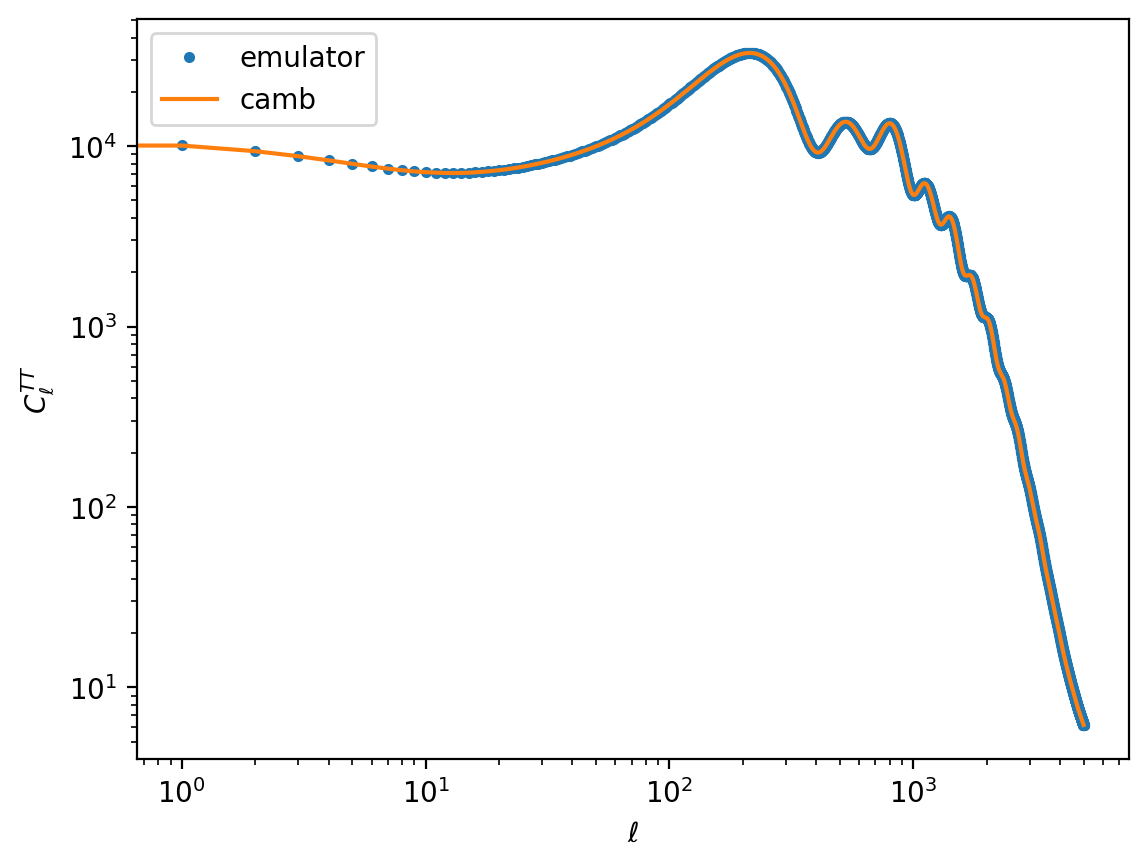

In [13]:
#Plot out one example to compare the difference between emulator and camb

ell=np.arange(2,5000,1)
plt.plot(pred[1000]*ell*(ell+1),'.',label='emulator')
plt.plot(testing_data_vectors[1000]*ell*(ell+1),label='camb')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{TT}$')
plt.legend()


In [14]:
#computing distribution of error on each mode for a shade plot
chiell=abs(pred-testing_data_vectors)*np.sqrt(np.diag(covinv))*100

q1=[]
q2=[]
q3=[]
for i in range(4998):
    sorteddif=np.sort(chiell[:,i])
    q1.append(sorteddif[int(8090*0.68-1)])
    q2.append(sorteddif[int(8090*0.95-1)])
    q3.append(sorteddif[int(8090*0.99-1)])
q1=np.array(q1)
q2=np.array(q2)
q3=np.array(q3)

Text(0.5, 0, '$\\ell$')

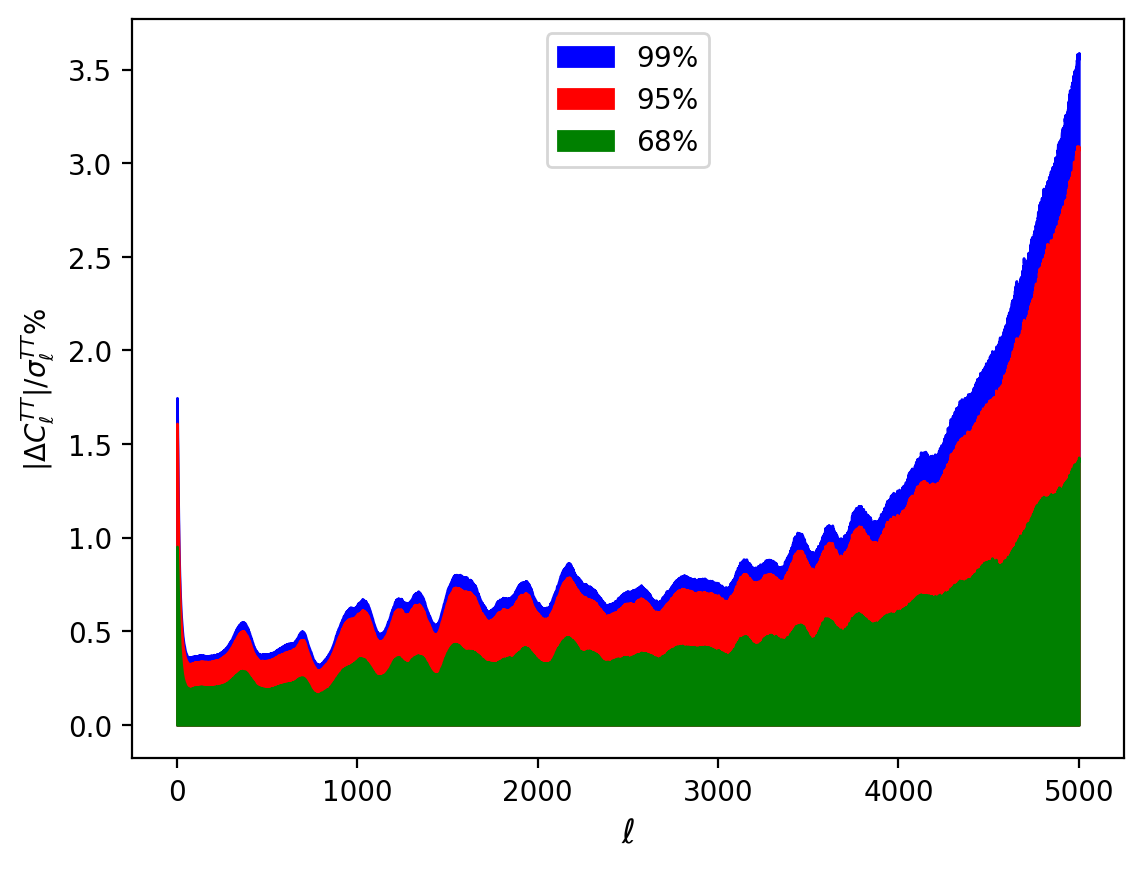

In [15]:
ell=np.arange(2,5000,1)

plt.fill_between(ell, q3, color='blue',label=r'$99\%$')
plt.fill_between(ell, q2, color='red',label=r'$95\%$')
plt.fill_between(ell, q1, color='green',label=r'$68\%$')
plt.legend(loc=9)
plt.ylabel(r'$|\Delta C_{\ell}^{TT}|/\sigma_{\ell}^{TT}$'+r'$\%$')
plt.xlabel(r'$\ell$',fontsize=12)
